In [1]:
import sys
sys.path.append('../src')
import numpy as np
import matplotlib.pyplot as plt
from world import Patch, Agent
from mvt_brr import MVTModel

In [2]:
# Step 2: Run Agents on the World Model

# Step 2a: Compute normative expected leaving time for each patch (assuming MVT)
def compute_mvt_leave_time(patch, background_reward_rate):
    time = 0
    while True:
        reward_rate = patch.initial_yield * np.exp(-patch.decay_rate * time)
        if reward_rate < background_reward_rate:
            break
        time += 1
    return time

In [3]:
# Step 1a: Specify a world with P patch types and N patches
P = 5  # Number of patch types
N = 10  # Number of patches
patch_types = np.random.choice(P, N, replace=True)
initial_yields = np.random.rand(P) * 10  # Initial yield for each patch type
decay_rate = 0.1  # Decay rate for all patches

In [8]:
print(patch_types, initial_yields)

[3 4 3 2 2 1 3 3 1 4] [6.48256025 2.45707664 7.75795556 1.46787679 2.97892723]


In [14]:
# Step 1a: Create patches based on the world specification
patches = [Patch(initial_yields[patch_type], decay_rate) for patch_type in patch_types]
agent = Agent(beta=0.7)  # Softmax parameter

In [5]:
# Initialize variables to track performance
leave_times = []

# Run simulation
total_rewards = []
for patch in patches:
    patch.start_harvesting()  # Start harvesting on the current patch
    rewards = []
    time = 0
    while True:
        reward = patch.get_reward()
        # rewards.append(reward)
        if agent.choose_action(reward) == 1:  # Decision to leave
            break
        time += 1
    leave_times.append(time)
    # total_rewards.append(sum(rewards))
    patch.harvesting = False  # Stop harvesting when leaving the patch

# Calculate mean and variance of leaving times
E_leave = np.mean(leave_times)
VAR_leave = np.var(leave_times)

print(f"Mean Leaving Time: {E_leave}")
print(f"Variance in Leaving Time: {VAR_leave}")

Mean Leaving Time: 5.8
Variance in Leaving Time: 42.36


In [6]:
leave_times

[2, 10, 0, 20, 14, 7, 1, 3, 1, 0]

In [9]:
background_reward_rate = np.mean(initial_yields) * decay_rate  # Simplified background reward rate

In [10]:
stay_times = [compute_mvt_leave_time(Patch(yield_, decay_rate),
                                    background_reward_rate) for yield_ in initial_yields]
stay_times

[28, 18, 30, 13, 20]

### Patch effect: Increasing yield

In [11]:
increased_yields = np.linspace(1, 20, P)
inc_background_reward_rate = np.mean(increased_yields) * decay_rate
longer_stay_times = [compute_mvt_leave_time(Patch(yield_, decay_rate), 
                                            inc_background_reward_rate) for yield_ in increased_yields]
longer_stay_times

[0, 18, 24, 27, 30]

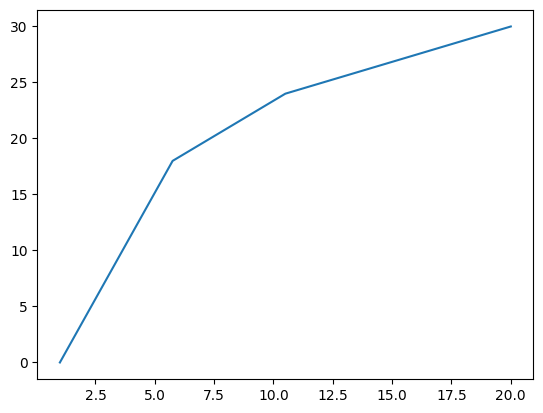

In [12]:
plt.plot(increased_yields, longer_stay_times, label='MVT Predicted Stay Times')

In [15]:
# Initialize patches and agents
def initialize_environment(patch_yields, decay_rate, beta, intercept=0):
    patches = [Patch(yield_val, decay_rate) for yield_val in patch_yields]
    agent = Agent(beta, intercept)
    return patches, agent

# Function to run simulation
def run_simulation(patches, agent):
    leave_times = []
    for patch in patches:
        patch.start_harvesting()  # Start harvesting on the current patch
        time = 0
        while True:
            reward = patch.get_reward()
            if agent.choose_action(reward) == 1:  # Decision to leave
                break
            time += 1
        leave_times.append(time)
        patch.harvesting = False  # Stop harvesting when leaving the patch
    return leave_times

In [57]:
# Function to compute MVT predictions for an environment
def compute_mvt_predictions(patch_yields, decay_rate):
    background_reward_rate = np.mean(patch_yields) * decay_rate
    print(f"Background Reward Rate: {background_reward_rate}")
    patches = [Patch(yield_val, decay_rate) for yield_val in patch_yields]
    mvt_leave_times = [compute_mvt_leave_time(patch, background_reward_rate) for patch in patches]
    print(f"MVT leave time prediction: {mvt_leave_times}")
    mean_mvt_leave_time = np.mean(mvt_leave_times)
    print(f"Mean MVT (leave): {mean_mvt_leave_time}")
    var_mvt_leave_time = np.var(mvt_leave_times)
    return mean_mvt_leave_time, var_mvt_leave_time

# Function to run the full experiment
def run_experiment(patch_yields, decay_rate, beta, intercept=0, num_patches=30):
    # Extend the patch yields to at least 30 patches
    extended_patch_yields = (patch_yields * (num_patches // len(patch_yields) + 1))[:num_patches]
    patches, agent = initialize_environment(extended_patch_yields, decay_rate, beta, intercept)
    leave_times = run_simulation(patches, agent)
    print(f"Agent leave times prediction: {leave_times}")
    mean_leave_time = np.mean(leave_times)
    print(f"Mean Agent (leave): {mean_leave_time}")
    var_leave_time = np.var(leave_times)
    mean_mvt_leave_time, var_mvt_leave_time = compute_mvt_predictions(extended_patch_yields, decay_rate)
    return mean_leave_time, var_leave_time, mean_mvt_leave_time, var_mvt_leave_time



Experiment: Yields
Agent leave times prediction: [0, 3, 9, 11, 8, 4, 6, 2, 3, 7, 13, 4, 3, 4, 11, 0, 1, 2, 10, 2, 4, 8, 10, 4, 8, 3, 7, 3, 3, 6]
Mean Agent (leave): 5.3
Background Reward Rate: 0.30000000000000004
MVT leave time prediction: [24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]
Mean MVT (leave): 24.0

Experiment: Increased Yield
Agent leave times prediction: [5, 13, 0, 6, 12, 7, 6, 15, 4, 7, 10, 0, 2, 14, 1, 1, 6, 5, 1, 14, 1, 1, 14, 1, 1, 18, 5, 8, 9, 3]
Mean Agent (leave): 6.333333333333333
Background Reward Rate: 0.30000000000000004
MVT leave time prediction: [19, 30, 13, 19, 30, 13, 19, 30, 13, 19, 30, 13, 19, 30, 13, 19, 30, 13, 19, 30, 13, 19, 30, 13, 19, 30, 13, 19, 30, 13]
Mean MVT (leave): 20.666666666666668

Experiment: Rich Environment
Agent leave times prediction: [1, 0, 0, 8, 8, 18, 5, 9, 5, 15, 7, 1, 6, 10, 8, 9, 12, 4, 12, 16, 0, 2, 11, 1, 14, 3, 10, 13, 17, 5]
Mean Agent (leave): 7.666666

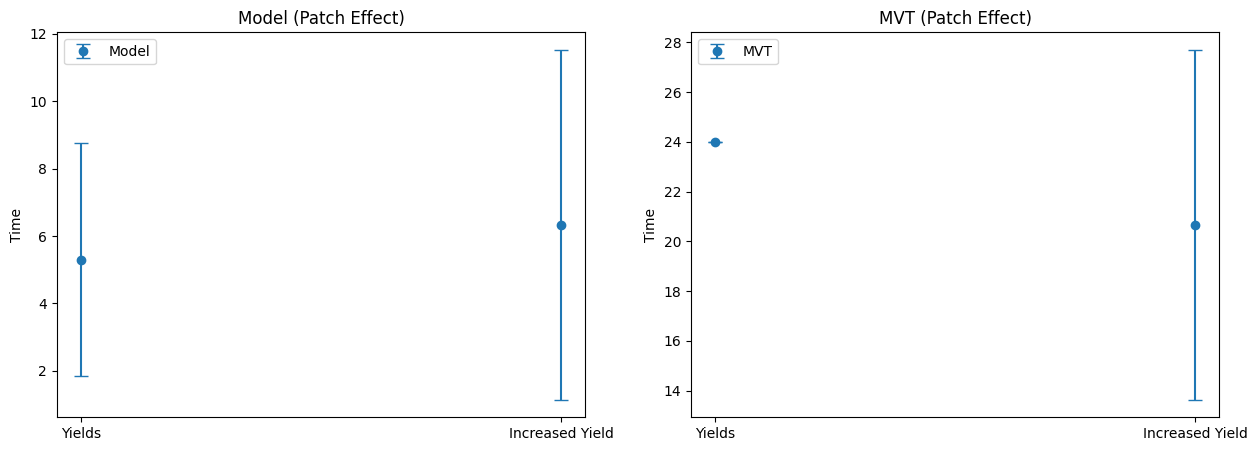

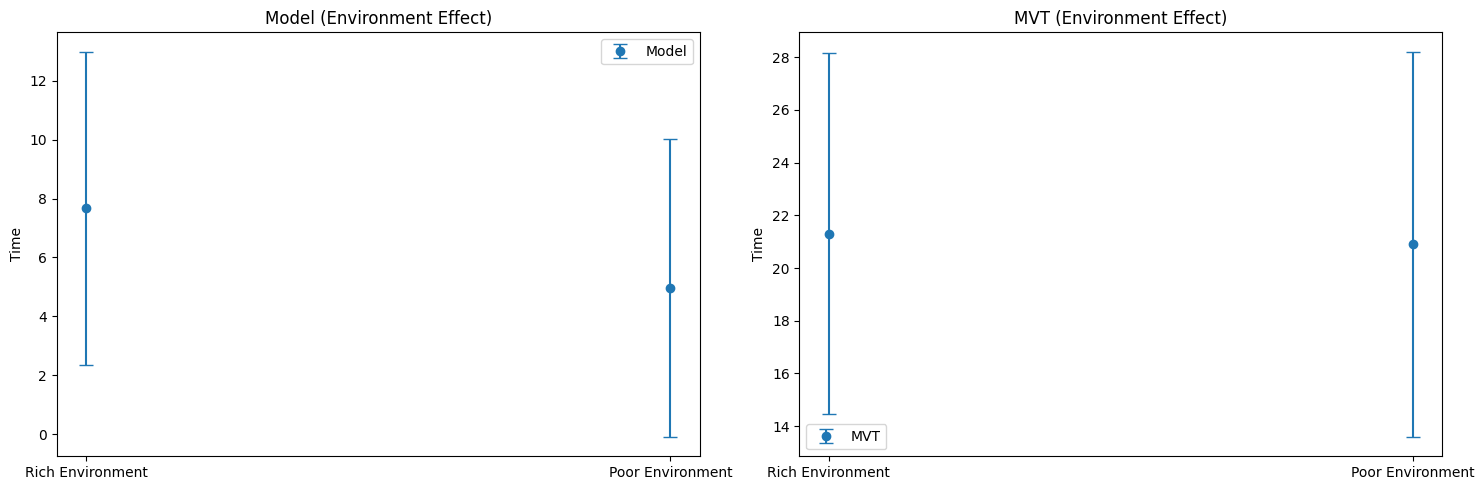

In [67]:
# Configurations for different scenarios
scenarios = {
    'Yields': [3, 3, 3],
    'Increased Yield': [2, 6, 1],
    'Rich Environment': [1, 1, 3, 3, 3, 6, 6, 6, 6, 6],
    'Poor Environment': [1, 1, 1, 1, 1, 3, 3, 3, 6, 6]
}

# Parameters
decay_rate = 0.1
beta = 0.85  # Higher beta means more likely to stay with higher rewards
intercept = 0.0

# Run experiments and collect results
results = {}
for scenario, patch_yields in scenarios.items():
    print(f"\nExperiment: {scenario}")
    results[scenario] = run_experiment(patch_yields, decay_rate, beta, intercept, num_patches=30)

# Extract mean and variance for plotting
scenarios_list = list(scenarios.keys())
mean_leave_times = [results[scenario][0] for scenario in scenarios_list]
variance_leave_times = [results[scenario][1] for scenario in scenarios_list]
mean_mvt_leave_times = [results[scenario][2] for scenario in scenarios_list]
variance_mvt_leave_times = [results[scenario][3] for scenario in scenarios_list]

# Plotting the results for scenarios 1 & 2 (Figure 1)
fig1, ax1 = plt.subplots(1, 2, figsize=(15, 5))

# Plot mean and variance of the model for scenarios 1 & 2
ax1[0].errorbar(scenarios_list[:2], mean_leave_times[:2], yerr=np.sqrt(variance_leave_times[:2]), fmt='o', capsize=5, label='Model')
ax1[0].set_title('Model (Patch Effect)')
ax1[0].set_ylabel('Time')
ax1[0].legend()

# Plot mean and variance of the MVT predictions for scenarios 1 & 2
ax1[1].errorbar(scenarios_list[:2], mean_mvt_leave_times[:2], yerr=np.sqrt(variance_mvt_leave_times[:2]), fmt='o', capsize=5, label='MVT')
ax1[1].set_title('MVT (Patch Effect)')
ax1[1].set_ylabel('Time')
ax1[1].legend()

# Plotting the results for scenarios 3 & 4 (Figure 2)
fig2, ax2 = plt.subplots(1, 2, figsize=(15, 5))

# Plot mean and variance of the model for scenarios 3 & 4
ax2[0].errorbar(scenarios_list[2:], mean_leave_times[2:], yerr=np.sqrt(variance_leave_times[2:]), fmt='o', capsize=5, label='Model')
ax2[0].set_title('Model (Environment Effect)')
ax2[0].set_ylabel('Time')
ax2[0].legend()

# Plot mean and variance of the MVT predictions for scenarios 3 & 4
ax2[1].errorbar(scenarios_list[2:], mean_mvt_leave_times[2:], yerr=np.sqrt(variance_mvt_leave_times[2:]), fmt='o', capsize=5, label='MVT')
ax2[1].set_title('MVT (Environment Effect)')
ax2[1].set_ylabel('Time')
ax2[1].legend()

plt.tight_layout()
plt.show()

08/07

In [109]:
# Simulation function
def simulate(environment, agent, model, n_runs=1000, n_max=1000):
    leave_times = []
    for _ in range(n_runs):
        patch = Patch(environment['initial_yield'], environment['decay_rate'])
        patch.start_harvesting()
        for t in range(1, n_max+1):
            reward = patch.get_reward()
            if model == 'epsilon_greedy':
                action = agent.choose_action_epsilon(reward, 0.1)
            else:
                action = agent.choose_action(reward)
            if action == 1:
                leave_times.append(t)
                break
    return leave_times

In [3]:
# Function to compute mean and variance
def compute_stats(leave_times):
    leave_times = np.array(leave_times)
    mean_leave_time = np.mean(leave_times)
    var_leave_time = np.var(leave_times)
    return mean_leave_time, var_leave_time

In [112]:
# Define environments
rich_env = [
    {'initial_yield': 32.5, 'decay_rate': 0.1},
    {'initial_yield': 45, 'decay_rate': 0.1},
    {'initial_yield': 57.5, 'decay_rate': 0.1}
]

poor_env = [
    {'initial_yield': 32.5, 'decay_rate': 0.1},
    {'initial_yield': 45, 'decay_rate': 0.1},
    {'initial_yield': 57.5, 'decay_rate': 0.1}
]

# Proportions
rich_proportions = [0.2, 0.3, 0.5]
poor_proportions = [0.5, 0.3, 0.2]

In [110]:
def prepare_results(beta_values, intercept_values, model):
    # Prepare data structures to hold results
    results = []

    for beta in beta_values:
        for intercept in intercept_values:
        # Initialize the agent with current beta and intercept
            agent = Agent(beta=beta, intercept=intercept)

        # Run simulations
            rich_stats = []
            poor_stats = []

            for env, proportion in zip(rich_env, rich_proportions):
                leave_times = simulate(env, agent, model, n_runs=int(1000 * proportion))
                stats = compute_stats(leave_times)
                rich_stats.append(stats)

            for env, proportion in zip(poor_env, poor_proportions):
                leave_times = simulate(env, agent, model, n_runs=int(1000 * proportion))
                stats = compute_stats(leave_times)
                poor_stats.append(stats)

        # Store results
            results.append({
            'beta': beta,
            'intercept': intercept,
            'rich_stats': rich_stats,
            'poor_stats': poor_stats
        })
    return results

# Define parameter ranges for beta and intercept
beta_values = [0.25, 0.5, 0.75]
intercept_values = [-1, 0, 1]
results = prepare_results(beta_values, intercept_values, 'epsilon_greedy')

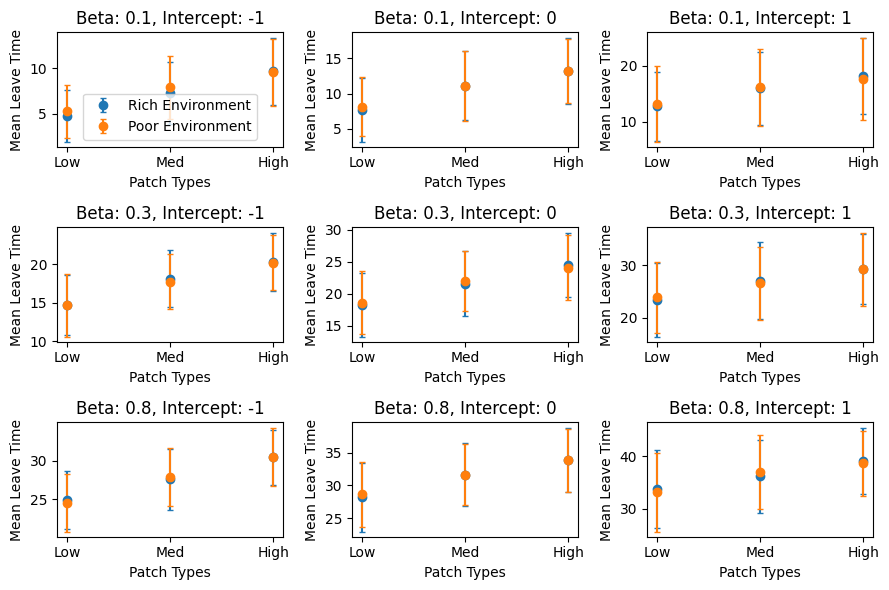

In [22]:
# Plotting
fig, axes = plt.subplots(len(beta_values), len(intercept_values), figsize=(9, 6))

for i, beta in enumerate(beta_values):
    for j, intercept in enumerate(intercept_values):
        ax = axes[i, j]
        
        # Extract results
        result = next(r for r in results if r['beta'] == beta and r['intercept'] == intercept)
        rich_stats = result['rich_stats']
        poor_stats = result['poor_stats']

        # Prepare data for plotting
        patch_types = ['Low', 'Med', 'High']

        rich_means = [stat[0] for stat in rich_stats]
        rich_vars = [stat[1] for stat in rich_stats]

        poor_means = [stat[0] for stat in poor_stats]
        poor_vars = [stat[1] for stat in poor_stats]

        # Plot for Rich Environment
        ax.errorbar(patch_types, rich_means, yerr=np.sqrt(rich_vars), fmt='o', label='Rich Environment', capsize=2)

        # Plot for Poor Environment
        ax.errorbar(patch_types, poor_means, yerr=np.sqrt(poor_vars), fmt='o', label='Poor Environment', capsize=2)

        # Adding labels and title
        ax.set_xlabel('Patch Types')
        ax.set_ylabel('Mean Leave Time')
        ax.set_title(f'Beta: {beta}, Intercept: {intercept}')
        if i == 0 and j == 0:
            ax.legend()

plt.tight_layout()
plt.show()

09/07

In [75]:
class StochasticChoiceModel:
    def __init__(self, beta, intercept=0):
        self.beta = beta
        self.intercept = intercept

    def leave_proba(self, reward):
        """ Compute the probability of leaving given the reward. """
        return 1 / (1 + np.exp(self.intercept + self.beta * reward))

def simulate_agent_in_patch(agent, patch, max_timesteps=1000):
    patch.start_harvesting()
    leave_probs = []
    cumulative_prob = 1.0  # Probability of not leaving until now
    expected_leave_time = 0.0
    variance_leave_time = 0.0

    for n in range(1, max_timesteps + 1):
        reward = patch.get_reward()
        prob_leave_now = agent.leave_proba(reward)
        prob_leave_n = prob_leave_now * cumulative_prob
        leave_probs.append(prob_leave_now)
        
        expected_leave_time += n * prob_leave_n
        cumulative_prob *= (1 - prob_leave_now)  # Update the cumulative probability

    # Calculating variance
    cumulative_prob = 1.0  # Reset for variance calculation
    for n in range(1, max_timesteps + 1):
        prob_leave_n = leave_probs[n-1] * cumulative_prob
        variance_leave_time += ((n - expected_leave_time) ** 2) * prob_leave_n
        cumulative_prob *= (1 - leave_probs[n-1])

    return expected_leave_time, variance_leave_time

# Example parameters
beta = 0.5
stochastic_agent = StochasticChoiceModel(beta=beta)

patches = {
    'low': Patch(32.5, 0.1, 'exponential'),
    'med': Patch(45, 0.05, 'exponential'),
    'high': Patch(57.5, 0.01, 'exponential')
}

# Run simulations and display results
results = {}
for name, patch in patches.items():
    expected_time, variance_time = simulate_agent_in_patch(stochastic_agent, patch)
    results[name] = {'Expected Leave Time': expected_time, 'Variance': variance_time}

for patch, res in results.items():
    print(f"Patch: {patch}, Expected Leave Time: {res['Expected Leave Time']:.2f}, Variance: {res['Variance']:.4f}")

Patch: low, Expected Leave Time: 23.57, Variance: 23.9795
Patch: med, Expected Leave Time: 47.14, Variance: 62.0045
Patch: high, Expected Leave Time: 210.08, Variance: 732.2180


17/07

In [7]:
model = MVTModel(decay_type='exponential')
Tmax_rich, Tmax_poor = model.run()

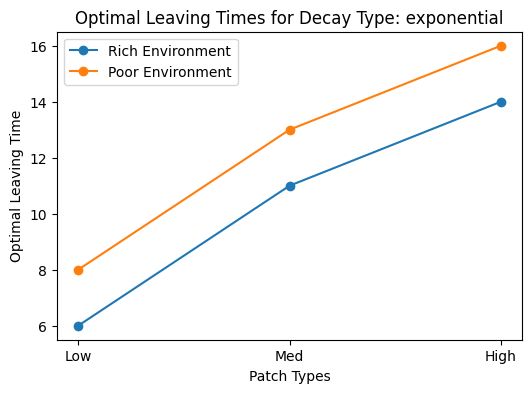

In [8]:
model.plot_results(Tmax_rich, Tmax_poor)

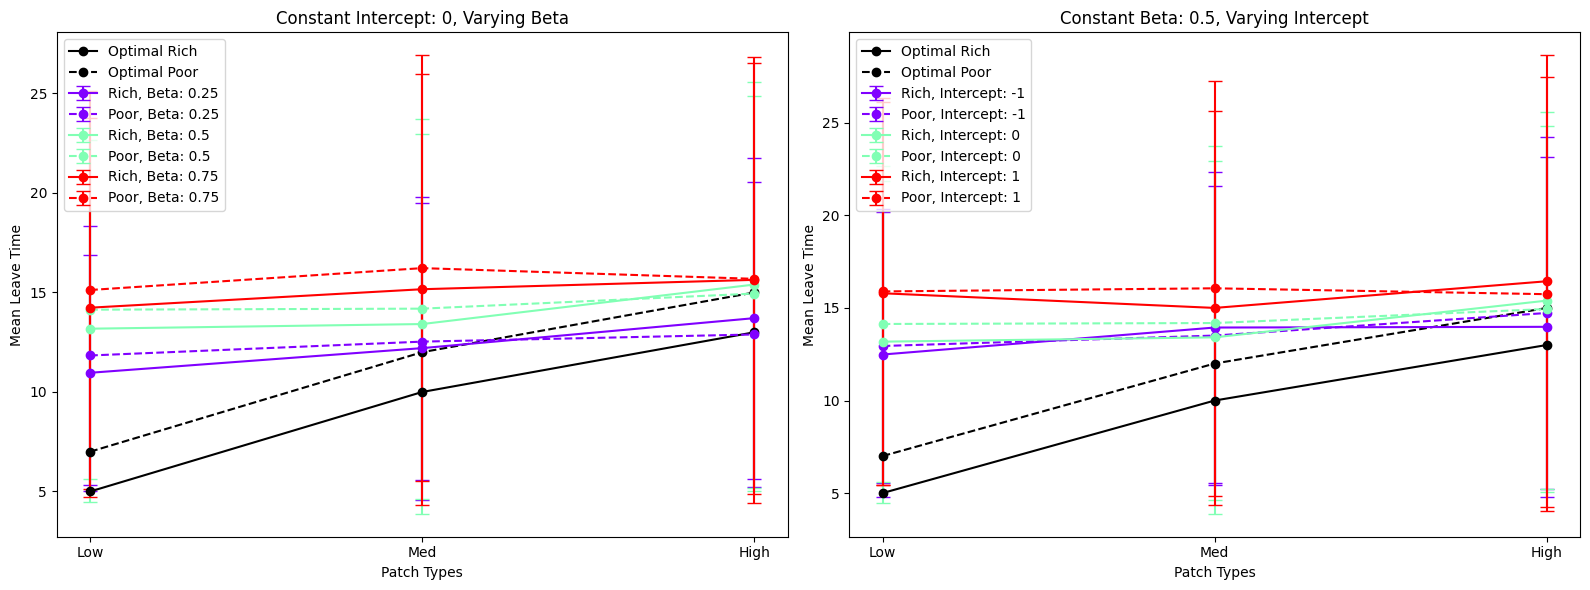

In [111]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define a color map for beta and intercept values
color_map = plt.cm.rainbow
beta_colors = {beta: color_map(i / (len(beta_values) - 1)) for i, beta in enumerate(beta_values)}
intercept_colors = {intercept: color_map(i / (len(intercept_values) - 1)) for i, intercept in enumerate(intercept_values)}

# Plot with constant intercept (choose a middle value)
constant_intercept = intercept_values[len(intercept_values)//2]
ax = axes[0]

for beta in beta_values:
    result = next(r for r in results if r['beta'] == beta and r['intercept'] == constant_intercept)
    rich_stats = result['rich_stats']
    poor_stats = result['poor_stats']

    patch_types = ['Low', 'Med', 'High']
    rich_means = [stat[0] for stat in rich_stats]
    poor_means = [stat[0] for stat in poor_stats]
    rich_errors = [np.sqrt(stat[1]) for stat in rich_stats]  # Standard deviation
    poor_errors = [np.sqrt(stat[1]) for stat in poor_stats]  # Standard deviation

    color = beta_colors[beta]
    ax.errorbar(patch_types, rich_means, yerr=rich_errors, marker='o', linestyle='-', color=color, label=f'Rich, Beta: {beta}', capsize=5)
    ax.errorbar(patch_types, poor_means, yerr=poor_errors, marker='o', linestyle='--', color=color, label=f'Poor, Beta: {beta}', capsize=5)
ax.plot(patch_types, Tmax_rich, marker='o', linestyle='-', color='black', label='Optimal Rich')
ax.plot(patch_types, Tmax_poor, marker='o', linestyle='--', color='black', label='Optimal Poor')

ax.set_xlabel('Patch Types')
ax.set_ylabel('Mean Leave Time')
ax.set_title(f'Constant Intercept: {constant_intercept}, Varying Beta')
ax.legend()

# Plot with constant beta (choose a middle value)
constant_beta = beta_values[len(beta_values)//2]
ax = axes[1]

for intercept in intercept_values:
    result = next(r for r in results if r['beta'] == constant_beta and r['intercept'] == intercept)
    rich_stats = result['rich_stats']
    poor_stats = result['poor_stats']

    patch_types = ['Low', 'Med', 'High']
    rich_means = [stat[0] for stat in rich_stats]
    poor_means = [stat[0] for stat in poor_stats]
    rich_errors = [np.sqrt(stat[1]) for stat in rich_stats]  # Standard deviation
    poor_errors = [np.sqrt(stat[1]) for stat in poor_stats]  # Standard deviation

    color = intercept_colors[intercept]
    ax.errorbar(patch_types, rich_means, yerr=rich_errors, marker='o', linestyle='-', color=color, label=f'Rich, Intercept: {intercept}', capsize=5)
    ax.errorbar(patch_types, poor_means, yerr=poor_errors, marker='o', linestyle='--', color=color, label=f'Poor, Intercept: {intercept}', capsize=5)
ax.plot(patch_types, Tmax_rich, marker='o', linestyle='-', color='black', label='Optimal Rich')
ax.plot(patch_types, Tmax_poor, marker='o', linestyle='--', color='black', label='Optimal Poor')

ax.set_xlabel('Patch Types')
ax.set_ylabel('Mean Leave Time')
ax.set_title(f'Constant Beta: {constant_beta}, Varying Intercept')
ax.legend()

plt.tight_layout()
plt.show()

In [101]:
# Prepare results for varying beta from 0 to 1 and plotting the expected leaving time
beta_values = np.linspace(0, 1, 21)  # 21 points from 0 to 1
intercept_values = [0]  # Fixed intercept at 0

results = prepare_results(beta_values, intercept_values)

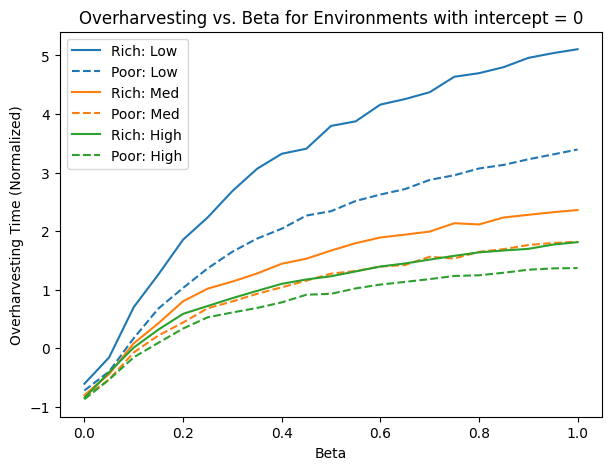

In [102]:
# Extract expected leaving times for each patch type in rich and poor environments
rich_leaving_times = ([[stat[0] for stat in result['rich_stats']] for result in results] - Tmax_rich) / Tmax_rich
poor_leaving_times = ([[stat[0] for stat in result['poor_stats']] for result in results] - Tmax_poor) / Tmax_poor

# Plot the results for rich environment
plt.figure(figsize=(7, 5))
for i in range(len(rich_leaving_times[0])):
    plt.plot(beta_values, [times[i] for times in rich_leaving_times], label=f'Rich: {patch_types[i]}')
    plt.plot(beta_values, [times[i] for times in poor_leaving_times], color=plt.gca().lines[-1].get_color(), linestyle='--', label=f'Poor: {patch_types[i]}')
    
plt.xlabel('Beta')
plt.ylabel('Overharvesting Time (Normalized)')
plt.title('Overharvesting vs. Beta for Environments with intercept = 0')
plt.legend()
plt.show()

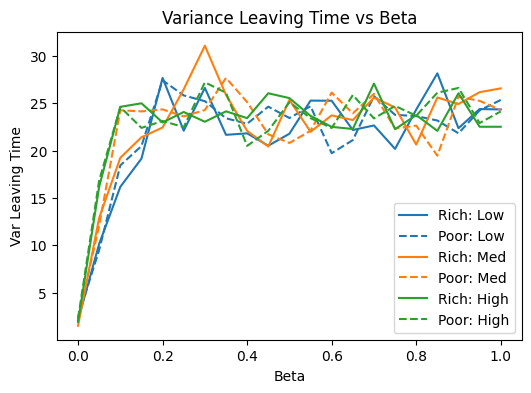

In [97]:
# Extract expected leaving times for each patch type in rich and poor environments
rich_leaving_times = [[stat[1] for stat in result['rich_stats']] for result in results]
poor_leaving_times = [[stat[1] for stat in result['poor_stats']] for result in results]

# Plot the results for rich environment
plt.figure(figsize=(6, 4))
for i in range(len(rich_leaving_times[0])):
    plt.plot(beta_values, [times[i] for times in rich_leaving_times], label=f'Rich: {patch_types[i]}')
    plt.plot(beta_values, [times[i] for times in poor_leaving_times], label=f'Poor: {patch_types[i]}', color=plt.gca().lines[-1].get_color(), linestyle='--',)

plt.xlabel('Beta')
plt.ylabel('Var Leaving Time')
plt.title('Variance Leaving Time vs Beta')
plt.legend()
plt.show()

In [98]:
# Prepare results for varying beta from 0 to 1 and plotting the expected leaving time
beta_values = [0.3]  # Two beta values
intercept_values = np.linspace(-2, 2, 31)  # Fixed intercept range

results = prepare_results(beta_values, intercept_values)

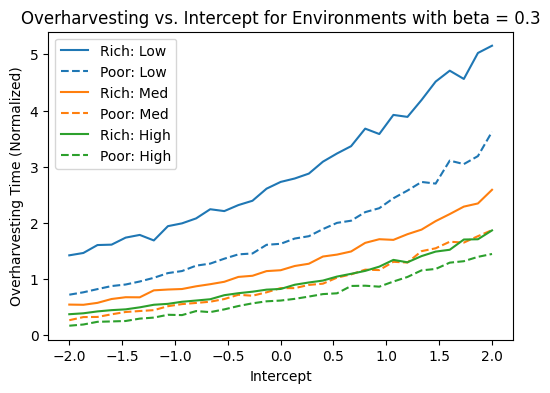

In [95]:
# Extract expected leaving times for each patch type in rich and poor environments
rich_leaving_times = ([[stat[0] for stat in result['rich_stats']] for result in results] - Tmax_rich) / Tmax_rich
poor_leaving_times = ([[stat[0] for stat in result['poor_stats']] for result in results] - Tmax_poor) / Tmax_poor

# Plot the results f
plt.figure(figsize=(6, 4))
for i in range(len(rich_leaving_times[0])):
    plt.plot(intercept_values, [times[i] for times in rich_leaving_times], label=f'Rich: {patch_types[i]}')
    plt.plot(intercept_values, [times[i] for times in poor_leaving_times], color=plt.gca().lines[-1].get_color(), linestyle='--', label=f'Poor: {patch_types[i]}')
    
plt.xlabel('Intercept')
plt.ylabel('Overharvesting Time (Normalized)')
plt.title('Overharvesting vs. Intercept for Environments with beta = 0.3')
plt.legend()
plt.show()

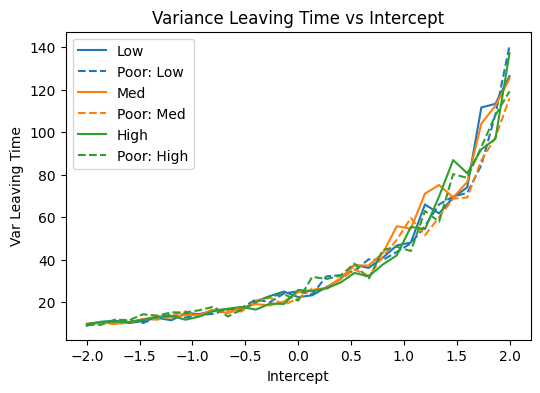

In [99]:
# Extract expected leaving times for each patch type in rich and poor environments
rich_leaving_times = [[stat[1] for stat in result['rich_stats']] for result in results]
poor_leaving_times = [[stat[1] for stat in result['poor_stats']] for result in results]

# Plot the results for rich environment
plt.figure(figsize=(6, 4))
for i in range(len(rich_leaving_times[0])):
    plt.plot(intercept_values, [times[i] for times in rich_leaving_times], label=f'{patch_types[i]}')
    plt.plot(intercept_values, [times[i] for times in poor_leaving_times], color=plt.gca().lines[-1].get_color(), linestyle='--', label=f'Poor: {patch_types[i]}')
    
plt.xlabel('Intercept')
plt.ylabel('Var Leaving Time')
plt.title('Variance Leaving Time vs Intercept')
plt.legend()
plt.show()